#### Importing the required libraries

In [1]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models


#### Importing the features of vgg19

In [2]:
vgg = models.vgg19(pretrained=True).features

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:06<00:00, 95.5MB/s]


#### Finding the parameters of the model

In [3]:
for param in vgg.parameters():
    param.requires_grad_(False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

#### Loading the image

In [4]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''

    image = Image.open(img_path).convert('RGB')

    # Large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    # Discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)

    return image


#### Uploading the Content and the Style images

In [5]:
content = load_image("/content/train.jpg")
style = load_image("/content/style.jpg", shape=content.size()[2:])


#### Converting the images into a tensor

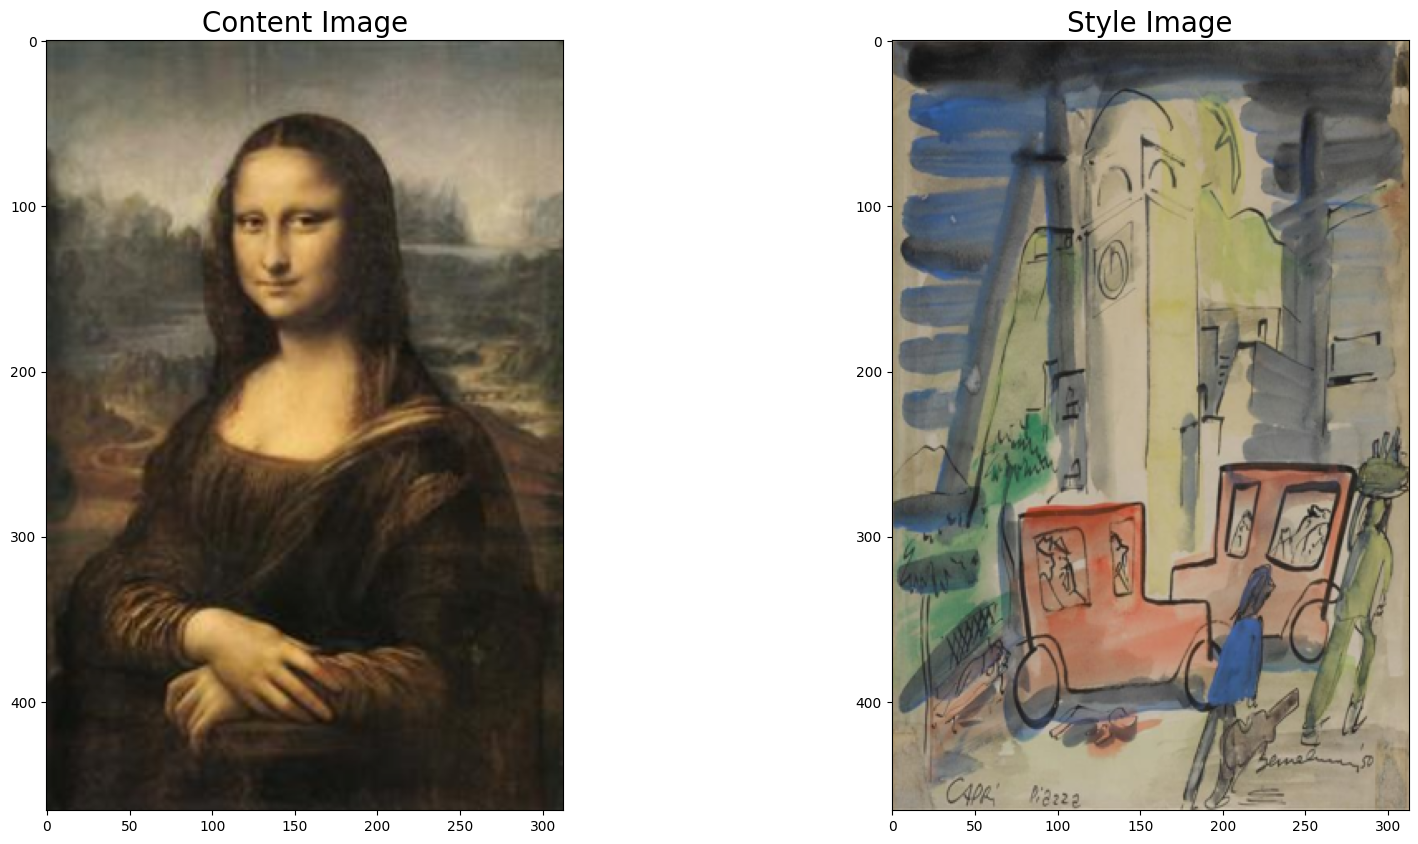

In [6]:
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# Content and style images side-by-side
ax1.imshow(im_convert(content))
ax1.set_title("Content Image", fontsize=20)
ax2.imshow(im_convert(style))
ax2.set_title("Style Image", fontsize=20)
plt.show()

#### Getting the features

In [7]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}

    features = {}
    x = image
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

#### Constructing a Gram-Matrix

In [8]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """

    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())

    return gram

In [9]:
# Move content and style images to the same device as vgg
content = content.to(device)
style = style.to(device)

# Move vgg model to the same device
vgg.to(device)

# Get content and style features
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)


In [10]:
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)


In [11]:
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# Create a third "target" image and prep it for change
# It is a good idea to start off with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

#### Defining the weights of the style image

In [12]:
style_weights = {'conv1_1': 1.0,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

# Set content and style weights
content_weight = 1  # alpha
style_weight = 1e9  # beta

# Calculate content loss
content_loss = torch.mean((get_features(target, vgg)['conv4_2'] - content_features['conv4_2'])**2)


#### Model Training ---->

Total loss:  4261453056.0


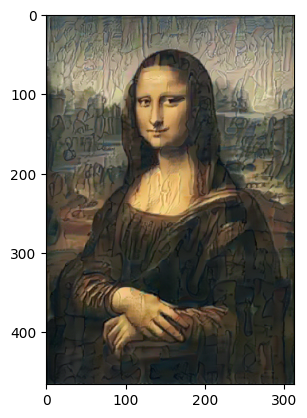

Total loss:  2221716224.0


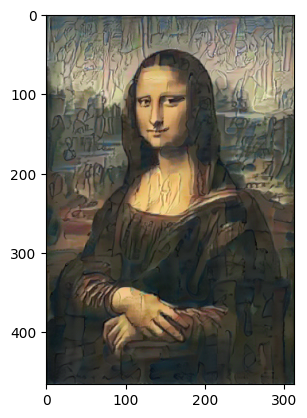

Total loss:  1430149760.0


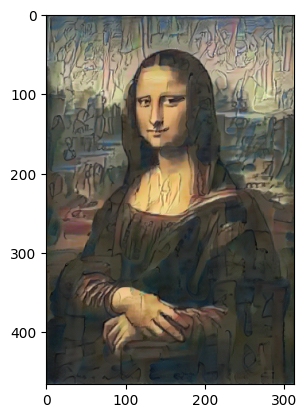

Total loss:  999234112.0


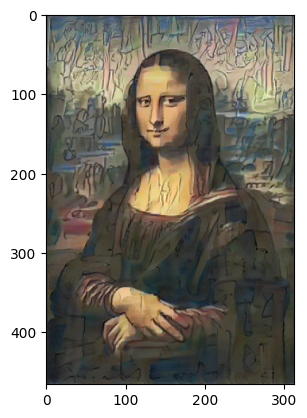

Total loss:  740020544.0


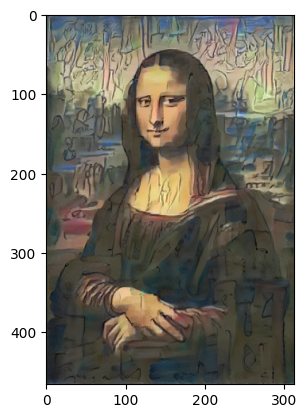

In [13]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):

    # get the features from your target image
    target_features = get_features(target, vgg)

    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)

    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

#### Display of the output

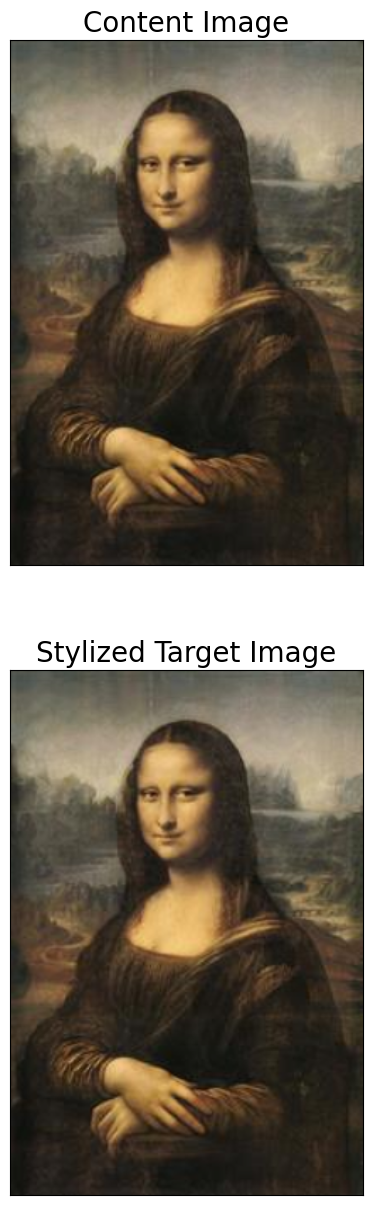

In [56]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
ax1.imshow(im_convert(content))
ax1.set_title("Content Image", fontsize = 20)
ax2.imshow(im_convert(target))
ax2.set_title("Stylized Target Image", fontsize = 20)
ax1.grid(False)
ax2.grid(False)
# Hide axes ticks
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()

In [57]:
# Create a third "target" image , so that it can be changed
target = content.clone().requires_grad_(True).to(device)


In [53]:
target

tensor([[[[-0.9534, -0.8849, -0.8164,  ..., -0.8507, -0.9192, -0.9363],
          [-0.8678, -0.7993, -0.7308,  ..., -0.7308, -0.7822, -0.7822],
          [-0.7993, -0.7308, -0.6623,  ..., -0.6109, -0.6281, -0.6109],
          ...,
          [-1.7412, -1.7240, -1.7240,  ..., -1.4672, -1.4672, -1.4500],
          [-1.6898, -1.7069, -1.7069,  ..., -1.4158, -1.4329, -1.4329],
          [-1.6384, -1.6727, -1.6898,  ..., -1.3644, -1.3987, -1.4158]],

         [[-0.7927, -0.7227, -0.6527,  ..., -0.7052, -0.7752, -0.7927],
          [-0.7052, -0.6352, -0.5651,  ..., -0.5826, -0.6352, -0.6352],
          [-0.6352, -0.5651, -0.4951,  ..., -0.4601, -0.4776, -0.4601],
          ...,
          [-1.6331, -1.6155, -1.6155,  ..., -1.3529, -1.3529, -1.3354],
          [-1.5805, -1.5980, -1.5980,  ..., -1.3004, -1.3179, -1.3179],
          [-1.5280, -1.5630, -1.5805,  ..., -1.2479, -1.2829, -1.3004]],

         [[-0.7238, -0.6541, -0.5844,  ..., -0.7064, -0.7761, -0.8110],
          [-0.6367, -0.5670, -

In [59]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''
    image = Image.open(img_path).convert('RGB')

    # Large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

    # Discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3, :, :].unsqueeze(0)

    return image


#### Evaluation of the model

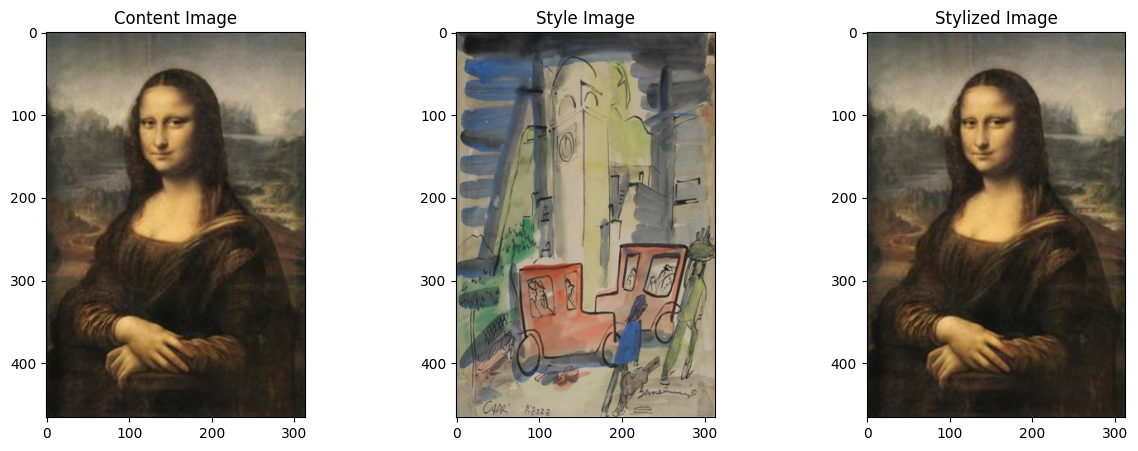

Structural Similarity Index (SSIM): 1.0
Perceptual Loss: 0.0


<ipython-input-54-0524dcc5bed2>:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return ssim(img1, img2, multichannel=True)


In [60]:
# Function to evaluate the model
def evaluate_model(target, content_image_path, style_image_path, save_path):
    # Load content and style images
    content_image = load_image(content_image_path)
    style_image = load_image(style_image_path, shape=content_image.size()[2:])

    # Move images to the same device as the model
    content_image = content_image.to(device)
    style_image = style_image.to(device)

    # Stylize the content image using the target tensor
    stylized_image = target

    # Visual Inspection
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(im_convert(content_image))
    ax1.set_title("Content Image")
    ax2.imshow(im_convert(style_image))
    ax2.set_title("Style Image")
    ax3.imshow(im_convert(stylized_image))
    ax3.set_title("Stylized Image")
    plt.show()

    # SSIM
    ssim_score = calculate_ssim(im_convert(content_image), im_convert(stylized_image))
    print(f"Structural Similarity Index (SSIM): {ssim_score}")

    # Perceptual Loss
    perceptual_loss = torch.mean((get_features(stylized_image, vgg)['conv4_2'] - get_features(content_image, vgg)['conv4_2'])**2)
    print(f"Perceptual Loss: {perceptual_loss.item()}")

# Example usage
content_image_path = "/content/train.jpg"
style_image_path = "/content/style.jpg"
save_path = "/content/stylized_image.jpg"

evaluate_model(target, content_image_path, style_image_path, save_path)


#### Saving the model

In [55]:
# Stylize the content image using the target tensor
stylized_target = target  # 'target' is the stylized image tensor

# Save the stylized image
save_path = "/content/stylized_image.jpg"
save_image(stylized_target, save_path)



#### Making sure that the model is transferable

In [47]:
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, utils

# Function to load an image and apply the necessary transformations
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')

    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    image = in_transform(image)[:3, :, :].unsqueeze(0)
    return image

# Function to convert a tensor to an image
def im_convert(tensor):
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1, 2, 0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
    return image

# Function to get features from a specific layer in the model
def get_features(image, model, layers=None):
    if layers is None:
        layers = {'0': 'conv1_1', '5': 'conv2_1', '10': 'conv3_1', '19': 'conv4_1', '21': 'conv4_2', '28': 'conv5_1'}

    features = {}
    x = image

    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

# Function to create a gram matrix
def gram_matrix(tensor):
    _, d, h, w = tensor.size()
    tensor = tensor.view(d, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Function to resize tensor to a target size
def resize_tensor(tensor, target_size):
    return F.interpolate(tensor, size=target_size, mode='bilinear', align_corners=False)

# Function to evaluate the model on a new artwork
def evaluate_model(model, content_image_path, style_image_path, save_path):
    content = load_image(content_image_path)
    style = load_image(style_image_path, shape=content.size()[2:])

    # Move content and style images to the same device as the model
    content = content.to(device)
    style = style.to(device)

    # Get content and style features
    content_features = get_features(content, model)
    style_features = get_features(style, model)
    style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

    # Create a third "target" image and prep it for change
    target = content.clone().requires_grad_(True).to(device)
    optimizer = optim.Adam([target], lr=0.01)
    steps = 500  # Adjust the number of iterations

    for ii in range(1, steps + 1):
        target_features = get_features(target, model)
        content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

        # Style loss
        style_loss = 0
        for layer in style_weights:
            target_feature = target_features[layer]
            target_gram = gram_matrix(target_feature)
            _, d, h, w = target_feature.shape
            style_gram = style_grams[layer]
            layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
            style_loss += layer_style_loss / (d * h * w)

        total_loss = content_weight * content_loss + style_weight * style_loss

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if ii % show_every == 0:
            print('Total loss: ', total_loss.item())

    # Save the stylized image
    utils.save_image(target, save_path)

# Load the pre-trained VGG model for fine-tuning
fine_tune_vgg = models.vgg19(pretrained=True).features.to(device)

# Freeze content layers
for param in fine_tune_vgg.parameters():
    param.requires_grad_(False)

# Load the pre-stylized target image obtained from the previous neural style transfer
stylized_target = load_image("/content/stylized_image.jpg").to(device).requires_grad_(True)

# Load the new artwork
new_artwork_path = "/content/wikiart.jpg"
new_artwork = load_image(new_artwork_path).to(device)

# Set parameters
num_epochs = 500
learning_rate = 0.001

# Content loss function
content_loss_fn = nn.MSELoss()

# Optimizer for fine-tuning
optimizer = optim.Adam([stylized_target], lr=learning_rate)

# Fine-tuning loop
for epoch in range(num_epochs):
    optimizer.zero_grad()

    # Forward pass
    stylized_output = stylized_target

    # Get features for stylized output and new artwork
    stylized_output_features = get_features(stylized_output, fine_tune_vgg)['conv4_2']
    new_artwork_features = get_features(new_artwork, fine_tune_vgg)['conv4_2']

    # Ensure that the spatial dimensions match
    if stylized_output_features.shape[2:] != new_artwork_features.shape[2:]:
        # Resize new_artwork_features to match the spatial dimensions of stylized_output_features
        new_artwork_features = resize_tensor(new_artwork_features, stylized_output_features.shape[2:])

    # Content loss between stylized output and original content
    content_loss = content_loss_fn(stylized_output_features, new_artwork_features)

    # Total loss for fine-tuning
    total_loss = content_loss

    # Backward pass and optimization
    total_loss.backward()
    optimizer.step()

    # Display intermediate results
    if epoch % 50 == 0:
        print(f"Epoch [{epoch}/{num_epochs}], Content Loss: {content_loss.item()}")


Epoch [0/500], Content Loss: 16.729841232299805
Epoch [50/500], Content Loss: 11.427108764648438
Epoch [100/500], Content Loss: 9.291455268859863
Epoch [150/500], Content Loss: 8.227352142333984
Epoch [200/500], Content Loss: 7.560880661010742
Epoch [250/500], Content Loss: 7.093216896057129
Epoch [300/500], Content Loss: 6.747285842895508
Epoch [350/500], Content Loss: 6.4683027267456055
Epoch [400/500], Content Loss: 6.2330756187438965
Epoch [450/500], Content Loss: 6.031684875488281
